<a href="https://colab.research.google.com/github/benihime91/pytorch_retinanet/blob/master/nbs/preprocess_pascal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# What GPU do we have ?
! nvidia-smi

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

In [ ]:
# install dependencies
%%shell
pip install pytorch-lightning wandb
pip install git+https://github.com/albumentations-team/albumentations

In [2]:
# Grab the Data
%%shell
unzip -qq /content/drive/My\ Drive/Pascal\ 2007\ Data/pascal_voc_2007_test.zip
unzip -qq /content/drive/My\ Drive/Pascal\ 2007\ Data/pascal_voc_2007_train_val.zip

In [3]:
# Clone the RetinaNet Repo:
! git clone https://github.com/benihime91/pytorch_retinanet.git

Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 1454 (delta 27), reused 34 (delta 16), pack-reused 1407
Receiving objects: 100% (1454/1454), 46.21 MiB | 24.57 MiB/s, done.
Resolving deltas: 100% (978/978), done.


In [4]:
import os
import sys
import warnings

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# use wandb to track experiments
import wandb
wandb.login()

In [20]:
from typing import *
import pandas as pd
import numpy as np
import re
import time
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateLogger,
)

from pytorch_retinanet.src.models import Retinanet
from pytorch_retinanet.src.utils.eval_utils import CocoEvaluator
from pytorch_retinanet.src.utils.eval_utils import get_coco_api_from_dataset
from pytorch_retinanet.src.utils.general_utils import Visualizer, xml_to_csv, ifnone
from pytorch_retinanet.src.utils.general_utils import collate_fn

pl.seed_everything(42)
pd.set_option("display.max_colwidth", None)

In [13]:
trn_annot_dir = '/content/pascal_voc_2007_train_val/Annotations' 
trn_img_dir = '/content/pascal_voc_2007_train_val/Images'

tst_annot_dir = '/content/pascal_voc_2007_test/Annotations'
tst_img_dir = '/content/pascal_voc_2007_test/Images'


# Create pandas DataFrame from the xmls
df_trn = xml_to_csv(trn_annot_dir)
df_tst = xml_to_csv(tst_annot_dir)
df_trn.head(5)

filename  width  height   class  xmin  ymin  xmax  ymax
0  003370.jpg    500     332   train   162    93   289   276
1  008756.jpg    500     375     cat   210   121   289   174
2  004326.jpg    500     349    bird    86    89   132   164
3  009027.jpg    500     375  bottle   181    76   238   183
4  008654.jpg    500     338    bird    40   116   259   257

In [10]:
def preprare_data(df:pd.DataFrame, img_dir:str, encoder:LabelEncoder=None):
    "preprocess the given data and returns a pandas dataframe & encoder"
    encoder = ifnone(encoder, LabelEncoder())
    # modify filename to point to the image path
    df["filename"] = [os.path.join(img_dir, idx) for idx in df.filename.values]
    # get labels from the filename
    try:
        df['labels'] = encoder.transform(df['class'].values)
    except:
        df['labels'] = encoder.fit_transform(df['class'].values)
    return df, encoder
    
def create_label_dict(dataframe: pd.DataFrame, encoder: LabelEncoder) -> Dict[int, str]:
    "Creates a label dictionary from the given dataframe `labels`"
    names = list(dataframe.labels.unique())
    names.sort()
    # Create the label dictionary
    label_dict = {
        idx: clas for idx, clas in zip(names, list(encoder.inverse_transform(names)))
    }
    return label_dict

In [16]:
df_trn, encoder = preprare_data(df_trn, img_dir=trn_img_dir)
df_trn.head(10)

filename  width  ...  ymax labels
0  /content/pascal_voc_2007_train_val/Images/003370.jpg    500  ...   276     18
1  /content/pascal_voc_2007_train_val/Images/008756.jpg    500  ...   174      7
2  /content/pascal_voc_2007_train_val/Images/004326.jpg    500  ...   164      2
3  /content/pascal_voc_2007_train_val/Images/009027.jpg    500  ...   183      4
4  /content/pascal_voc_2007_train_val/Images/008654.jpg    500  ...   257      2
5  /content/pascal_voc_2007_train_val/Images/006762.jpg    500  ...   351     13
6  /content/pascal_voc_2007_train_val/Images/006762.jpg    500  ...   296     14
7  /content/pascal_voc_2007_train_val/Images/006762.jpg    500  ...   322     14
8  /content/pascal_voc_2007_train_val/Images/002783.jpg    500  ...   354      5
9  /content/pascal_voc_2007_train_val/Images/002783.jpg    500  ...   337      6

[10 rows x 9 columns]

In [15]:
df_tst, _ = preprare_data(df_tst, img_dir=tst_img_dir, encoder=encoder)
df_tst.head(10)

filename  width  ...  ymax labels
0  /content/pascal_voc_2007_test/Images/009319.jpg    500  ...   465     19
1  /content/pascal_voc_2007_test/Images/009319.jpg    500  ...    48     19
2  /content/pascal_voc_2007_test/Images/009922.jpg    500  ...   310     11
3  /content/pascal_voc_2007_test/Images/005887.jpg    500  ...   332     14
4  /content/pascal_voc_2007_test/Images/005887.jpg    500  ...   332     14
5  /content/pascal_voc_2007_test/Images/003237.jpg    334  ...   461     12
6  /content/pascal_voc_2007_test/Images/003237.jpg    334  ...   256     14
7  /content/pascal_voc_2007_test/Images/000043.jpg    333  ...   375     14
8  /content/pascal_voc_2007_test/Images/000043.jpg    333  ...   500     14
9  /content/pascal_voc_2007_test/Images/000043.jpg    333  ...   500     14

[10 rows x 9 columns]

In [19]:
# Grab the label dictionary
label_dict = create_label_dict(df_trn, encoder)
label_dict

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

In [21]:
# save the label_dict dictionary
f = open("/content/drive/My Drive/Pascal 2007 Data/names.pkl", "wb")
pickle.dump(label_dict, f)
f.close()

In [22]:
# crosscheck
label_dict = pickle.load(open("/content/drive/My Drive/Pascal 2007 Data/names.pkl", "rb"))
print(label_dict)

{0: 'aeroplane', 1: 'bicycle', 2: 'bird', 3: 'boat', 4: 'bottle', 5: 'bus', 6: 'car', 7: 'cat', 8: 'chair', 9: 'cow', 10: 'diningtable', 11: 'dog', 12: 'horse', 13: 'motorbike', 14: 'person', 15: 'pottedplant', 16: 'sheep', 17: 'sofa', 18: 'train', 19: 'tvmonitor'}


In [23]:
# Instantiate the visualizer
viz = Visualizer(class_names=label_dict)

In [28]:
def display_random_image(df: pd.DataFrame) -> None:
    "displays a radom Image from given dataframe"
    n = np.random.randint(0, len(df))
    fname = df["filename"][n]
    boxes = df.loc[df["filename"] == fname][["xmin", "ymin", "xmax", "ymax"]].values
    labels = df.loc[df["filename"] == fname]["labels"].values
    viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10, 10))

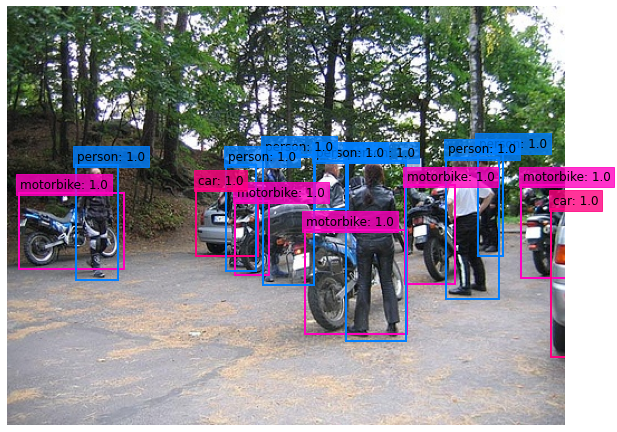

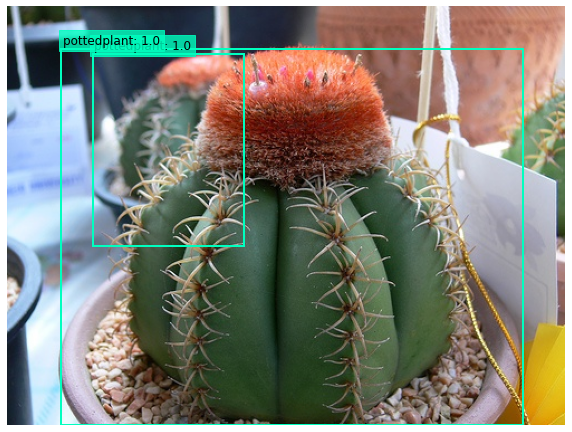

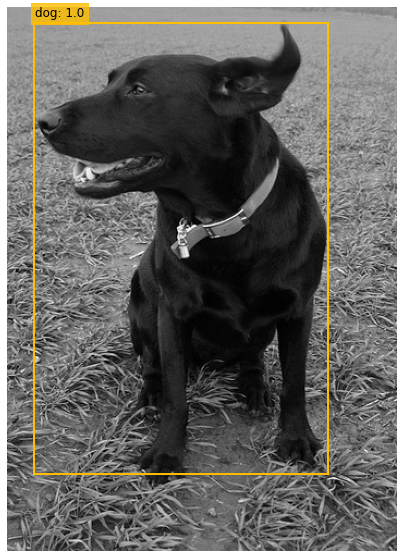

In [29]:
# Display some random Images from the Dataset for sanity check
display_random_image(df_trn)
display_random_image(df_trn)
display_random_image(df_tst)

In [30]:
def create_splits(
    df: pd.DataFrame, split_sz: float = 0.3
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    "Split given DataFrame into `split_sz`"
    # Grab the Unique Image Idxs from the Filename
    unique_ids = list(df.filename.unique())
    # Split the Unique Image Idxs into Train & valid Datasets
    train_ids, val_ids = train_test_split(
        unique_ids, shuffle=True, random_state=42, test_size=split_sz
    )

    # Create Splits on the DataFrame
    df["split"] = 0

    for i, idx in enumerate(df.filename.values):
        if idx in set(train_ids):
            df["split"][i] = "train"
        elif idx in set(val_ids):
            df["split"][i] = "val"

    # Split the DataFrame into Train and Valid DataFrames
    df_trn, df_val = df.loc[df["split"] == "train"], df.loc[df["split"] == "val"]
    df_trn, df_val = df_trn.reset_index(drop=True), df_val.reset_index(drop=True)

    # drop the extra redundent column
    df_trn.drop(columns=["split"], inplace=True)
    df_val.drop(columns=["split"], inplace=True)

    return df_trn, df_val

In [31]:
# Split the data into train & validation sets:
df_trn, df_val = create_splits(df_trn)

print('Num examples in train dataset', len(df_trn.filename.unique()))
print('Num examples in train dataset', len(df_val.filename.unique()))
print('Num examples in train dataset', len(df_tst.filename.unique()))

Num examples in train dataset 3507
Num examples in train dataset 1504
Num examples in train dataset 4952


In [32]:
df_trn.head()

filename  width  ...  ymax labels
0  /content/pascal_voc_2007_train_val/Images/003370.jpg    500  ...   276     18
1  /content/pascal_voc_2007_train_val/Images/008756.jpg    500  ...   174      7
2  /content/pascal_voc_2007_train_val/Images/004326.jpg    500  ...   164      2
3  /content/pascal_voc_2007_train_val/Images/009027.jpg    500  ...   183      4
4  /content/pascal_voc_2007_train_val/Images/008654.jpg    500  ...   257      2

[5 rows x 9 columns]

In [33]:
df_val.head()

filename  width  ...  ymax labels
0  /content/pascal_voc_2007_train_val/Images/009772.jpg    375  ...   500      7
1  /content/pascal_voc_2007_train_val/Images/003176.jpg    375  ...   311      6
2  /content/pascal_voc_2007_train_val/Images/009126.jpg    500  ...   268      5
3  /content/pascal_voc_2007_train_val/Images/009700.jpg    500  ...   242     16
4  /content/pascal_voc_2007_train_val/Images/009213.jpg    500  ...   287      6

[5 rows x 9 columns]

In [34]:
df_tst.head()

filename  width  ...  ymax labels
0  /content/pascal_voc_2007_test/Images/009319.jpg    500  ...   465     19
1  /content/pascal_voc_2007_test/Images/009319.jpg    500  ...    48     19
2  /content/pascal_voc_2007_test/Images/009922.jpg    500  ...   310     11
3  /content/pascal_voc_2007_test/Images/005887.jpg    500  ...   332     14
4  /content/pascal_voc_2007_test/Images/005887.jpg    500  ...   332     14

[5 rows x 9 columns]

In [35]:
# Save the DatFrames:
df_trn.to_csv('/content/drive/My Drive/Pascal 2007 Data/trn_data.csv', index=False)
df_val.to_csv('/content/drive/My Drive/Pascal 2007 Data/val_data.csv', index=False)
df_tst.to_csv('/content/drive/My Drive/Pascal 2007 Data/tst_data.csv', index=False)

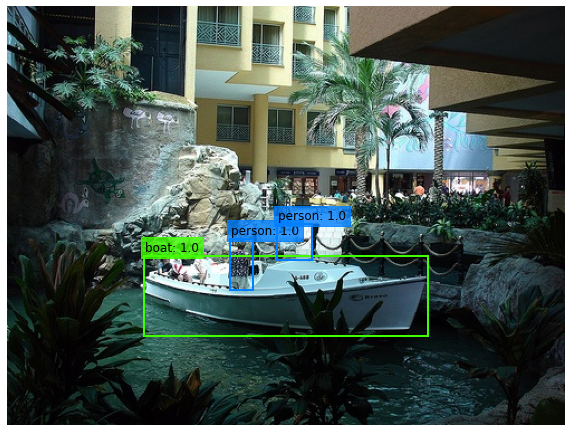

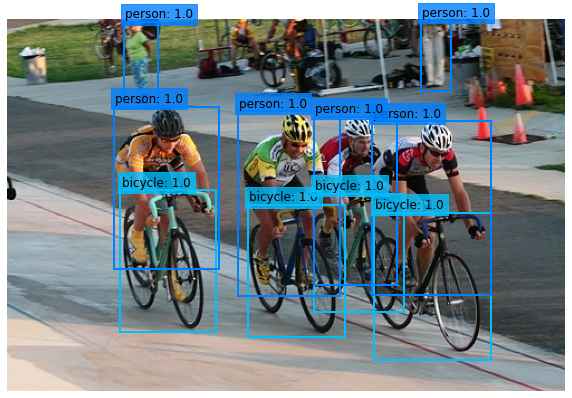

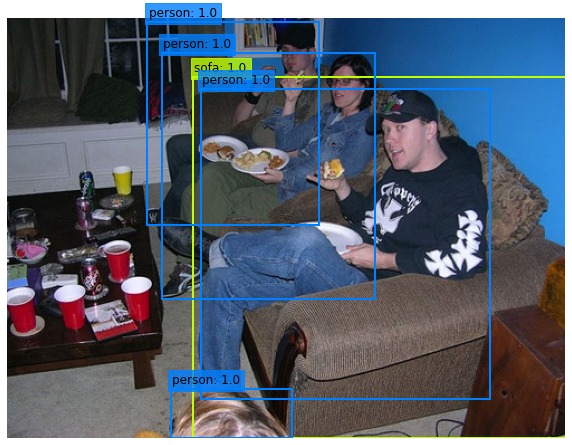

In [36]:
display_random_image(df_trn)
display_random_image(df_trn)
display_random_image(df_trn)

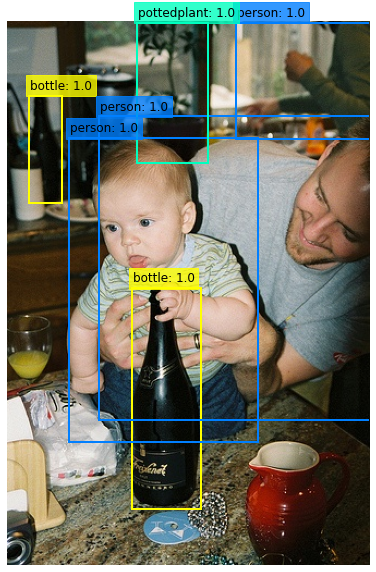

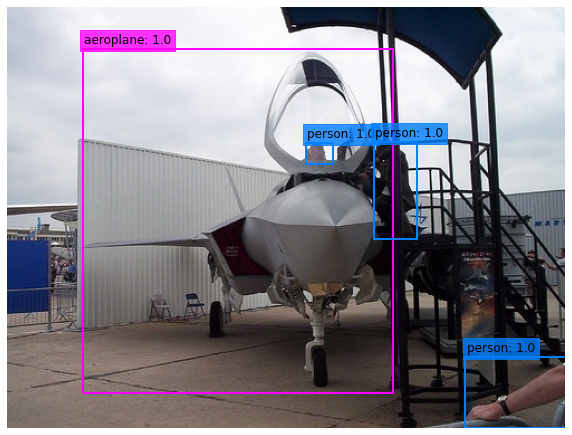

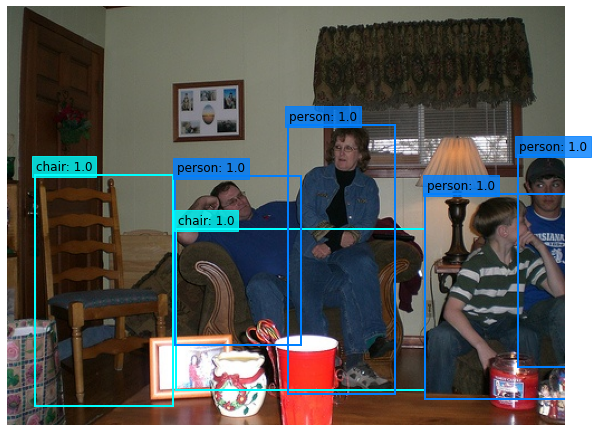

In [37]:
display_random_image(df_val)
display_random_image(df_val)
display_random_image(df_val)

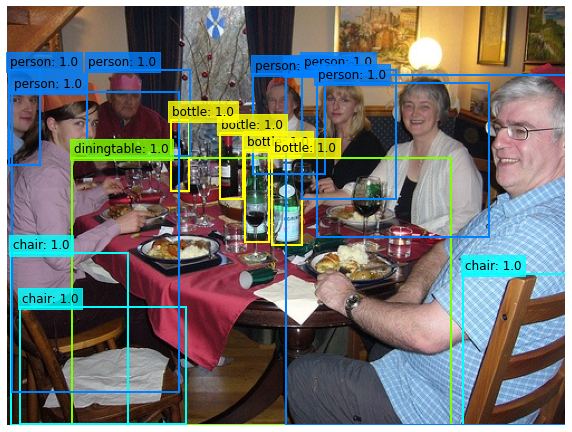

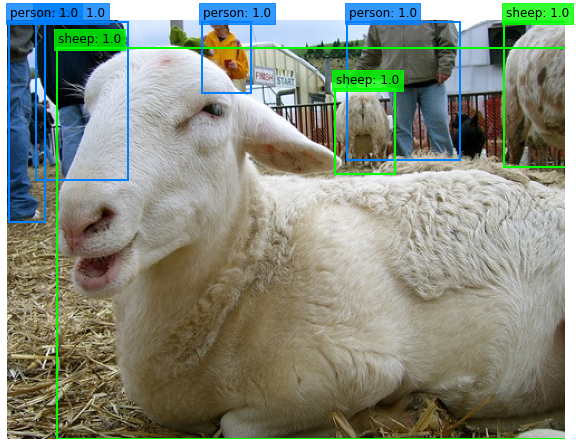

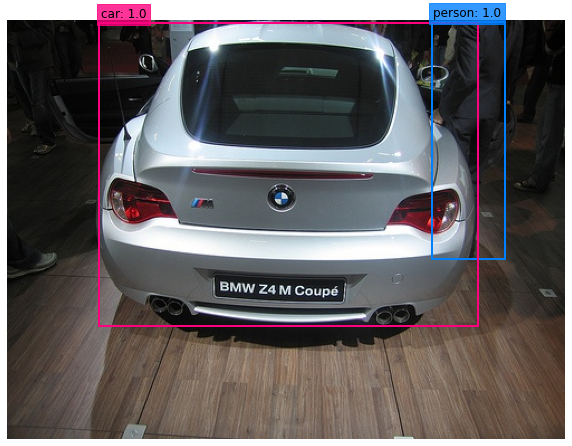

In [38]:
display_random_image(df_tst)
display_random_image(df_tst)
display_random_image(df_tst)